# Import required libraries

In [27]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Reading Data with sqlite

In [2]:
con = sqlite3.connect('E:\\IIT Kanpur\\Placements\\Projects\\Amazon Fine Food Reviews\\Dataset\\database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

In [3]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

# Binary Classfication

In [4]:
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Data deduplication

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
print((final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

(364173, 10)
69.25890143662969


In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [7]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


# Loading W2V_TF-IDF matrix previously saved

In [8]:
w2v_tfidf = pd.read_csv("E:\\IIT Kanpur\\Placements\\Projects\\Amazon Fine Food Reviews\\w2v_tfidf.csv")

In [9]:
w2v_tfidf.drop(w2v_tfidf.columns[[0]], axis = 1, inplace = True)

In [10]:
a = np.asarray(final['Score'])
print(np.count_nonzero(np.isnan(a)))

w2v_tfidf['Score'] = a

0


In [11]:
a = np.asarray(final['Time'])
print(np.count_nonzero(np.isnan(a)))

w2v_tfidf['TimeStamp'] = a

0


# Random Smapling 5% from the whole data

In [12]:
w2v_tfidf.shape

(364171, 52)

In [13]:
np.random.seed(1)
rand_ind = np.random.choice(w2v_tfidf.shape[0], int(0.05 * w2v_tfidf.shape[0]), replace=False)

w2v_tfidf_rand = np.asarray(w2v_tfidf)[rand_ind, :]

In [14]:
X = w2v_tfidf_rand[:, :50]
Y = w2v_tfidf_rand[:, 50:51]

### Train/Test split in ratio 80 : 20

In [15]:
from sklearn.model_selection import train_test_split

X = w2v_tfidf_rand[:, :50]
Y = w2v_tfidf_rand[:, 50:51]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(14566, 50) (3642, 50) (14566, 1) (3642, 1)


# Handling Class imbalance Problem

In [16]:
data = pd.DataFrame(X_train)
data['y'] = Y_train
data.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,y
0,-0.564001,-0.058113,0.601339,-0.281035,-0.119473,0.153355,-0.216625,-0.148660,-0.636599,-0.743581,...,0.532462,-1.075412,-1.332488,-0.347399,0.593220,0.594633,-0.358533,0.210341,-0.608107,1.0
1,2.067735,-0.904856,0.934154,-0.464753,0.546090,-0.037378,0.345049,0.578616,-0.511612,-0.055142,...,0.655825,-1.932175,-0.007415,-0.630967,0.237394,1.608986,2.027691,-0.564050,-1.300743,1.0
2,-0.412715,-1.131648,-0.121621,0.309196,0.712931,-0.078577,1.580521,-0.021504,-1.155676,-1.020775,...,-0.039613,0.215575,-1.887987,-0.873798,0.208267,0.023842,0.176566,0.518347,0.016671,1.0
3,-0.319674,-0.216596,0.278472,-0.388042,0.449741,-0.805975,0.459316,-0.469995,-0.305820,-0.508212,...,0.072224,-0.453960,-0.446523,-0.469024,-0.051081,0.436374,-0.067353,-0.320455,-0.445937,1.0
4,0.469712,0.157217,-0.681802,-1.111380,0.397916,0.108865,-1.140457,-0.392039,-0.757706,-0.878586,...,-0.711121,-0.813196,0.405295,-0.381188,0.636632,0.171218,1.058547,0.170746,0.770526,1.0


In [17]:
data['y'].value_counts()

1.0    12311
0.0     2255
Name: y, dtype: int64

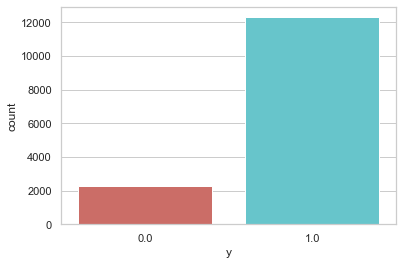

In [18]:
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x = 'y', data=data, palette = 'hls')
plt.show()

## Handling class imbalance problem

In [19]:
data_y_1 = data[data['y'] == 1.]
data_y_0 = data[data['y'] == 0.]

In [20]:
data_y_1 = data_y_1.sample(frac = 1).reset_index(drop=True)

In [21]:
data_y_1_trunc = data_y_1.iloc[:2255, :]

In [22]:
both_df = [data_y_0, data_y_1_trunc]

In [23]:
data_final = pd.concat(both_df, ignore_index = True)

In [24]:
data_final.shape

(4510, 51)

In [25]:
data_final = data_final.sample(frac = 1).reset_index(drop=True)

In [26]:
data_final['y'].value_counts()

1.0    2255
0.0    2255
Name: y, dtype: int64

# Application of Model

## Logistic Regression

In [144]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

Y = data_final.loc[:, data_final.columns == 'y']
X = data_final.loc[:, data_final.columns != 'y']

logit_model = sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.405216
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.415    
Dependent Variable: y                AIC:              3755.0481
Date:               2020-07-10 12:48 BIC:              4075.7507
No. Observations:   4510             Log-Likelihood:   -1827.5  
Df Model:           49               LL-Null:          -3126.1  
Df Residuals:       4460             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
------------------------------------------------------------------
0         0.5103     0.1086    4.6999   0.0000    0.2975    0.7231
1        -0.2741     0.1043   -2.6280   0.0086   -0.4785   -0.0697
2  

In [145]:
a = [5, 9, 11, 12, 13, 16, 21, 24, 29,37,39,43,45,47]

In [146]:
X.drop(X.columns[a], axis = 1, inplace = True)

In [147]:
X.shape

(4510, 36)

In [148]:
logit_model = sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.407213
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.413    
Dependent Variable: y                AIC:              3745.0591
Date:               2020-07-10 12:48 BIC:              3975.9650
No. Observations:   4510             Log-Likelihood:   -1836.5  
Df Model:           35               LL-Null:          -3126.1  
Df Residuals:       4474             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
0        0.4816     0.0930     5.1761   0.0000    0.2992    0.6639
1       -0.3043     0.0972    -3.1305   0.0017   -0.4948   -0.1138
2  

In [149]:
a = [4,9,21,32]
X.drop(X.columns[a], axis = 1, inplace = True)
X.shape

(4510, 32)

In [150]:
logit_model = sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.409877
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.409    
Dependent Variable: y                AIC:              3761.0861
Date:               2020-07-10 12:48 BIC:              3966.3358
No. Observations:   4510             Log-Likelihood:   -1848.5  
Df Model:           31               LL-Null:          -3126.1  
Df Residuals:       4478             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
0        0.4547     0.0902     5.0400   0.0000    0.2779    0.6316
1       -0.3068     0.0963    -3.1870   0.0014   -0.4955   -0.1181
2  

In [151]:
a = [7,16]
X.drop(X.columns[a], axis = 1, inplace = True)
X.shape

(4510, 30)

In [152]:
logit_model = sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.412207
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.405    
Dependent Variable: y                AIC:              3778.1112
Date:               2020-07-10 12:48 BIC:              3970.5327
No. Observations:   4510             Log-Likelihood:   -1859.1  
Df Model:           29               LL-Null:          -3126.1  
Df Residuals:       4480             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
0        0.3546     0.0857     4.1391   0.0000    0.1867    0.5225
1       -0.3827     0.0940    -4.0731   0.0000   -0.5668   -0.1985
2  

In [153]:
a = [13, 16]
X.drop(X.columns[a], axis = 1, inplace = True)
X.shape

(4510, 28)

In [154]:
logit_model = sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.413759
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.403    
Dependent Variable: y                AIC:              3788.1093
Date:               2020-07-10 12:48 BIC:              3967.7028
No. Observations:   4510             Log-Likelihood:   -1866.1  
Df Model:           27               LL-Null:          -3126.1  
Df Residuals:       4482             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
0        0.3081     0.0815     3.7803   0.0002    0.1483    0.4678
1       -0.4078     0.0929    -4.3876   0.0000   -0.5900   -0.2256
2  

In [155]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [156]:
X_test_df = pd.DataFrame(X_test)

In [157]:
final_cols = X.columns

In [158]:
X_test_df = X_test_df.iloc[:, [0,1,2,3,6,7,8,15,17,18,19,20,22,25,27,31,32,33,34,35,36,38,40,41,42,46,48,49]]

In [159]:
X_test_df.shape

(3642, 28)

In [161]:
y_pred = logreg.predict(X_test_df)

In [164]:
y_pred.shape, Y_test.shape

((3642,), (3642, 1))

In [165]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(Y_test, y_pred)
print(conf_mat)

print(classification_report(Y_test, y_pred))

[[ 479  111]
 [ 662 2390]]
              precision    recall  f1-score   support

         0.0       0.42      0.81      0.55       590
         1.0       0.96      0.78      0.86      3052

    accuracy                           0.79      3642
   macro avg       0.69      0.80      0.71      3642
weighted avg       0.87      0.79      0.81      3642



## Random Forest

In [31]:
X_train = data_final.iloc[:, :50]
Y_train = data_final.iloc[:, 50:]

In [32]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators =100, 
                               bootstrap = True,
                               max_features = 'sqrt')

model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(Y_test, y_probs)
print(roc_value)

### Optimizing the parameters, best fit randomforest

In [35]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 0)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=0)

# Fit 
rs.fit(X_train, Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   53.1s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [36]:
rs.best_params_

{'n_estimators': 83,
 'min_samples_split': 2,
 'max_leaf_nodes': 38,
 'max_features': 0.7,
 'max_depth': 6,
 'bootstrap': True}

In [37]:
best_model = rs.best_estimator_

y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

roc_value = roc_auc_score(Y_test, y_probs)
print(roc_value)

0.8306656374258614


In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(Y_test, y_pred)
print(conf_mat)

print('*'*100)

precision = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[1,0])
recall = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[0,1])
print(precision, recall)

print('*'*100)

print(classification_report(Y_test, y_pred))

[[ 453  137]
 [ 755 2297]]
****************************************************************************************************
0.7526212319790302 0.9437140509449465
****************************************************************************************************
              precision    recall  f1-score   support

         0.0       0.38      0.77      0.50       590
         1.0       0.94      0.75      0.84      3052

    accuracy                           0.76      3642
   macro avg       0.66      0.76      0.67      3642
weighted avg       0.85      0.76      0.78      3642



## Support Vectore machine

In [40]:
X_train = data_final.iloc[:, :50]
Y_train = data_final.iloc[:, 50:]

In [45]:
from sklearn.svm import SVC # "Support Vector Classifier" 
clf = SVC(kernel='linear') 
  
# fitting x samples and y classes 
clf.fit(X_train, Y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [48]:
y_pred = clf.predict(X_test)

In [49]:
conf_mat = confusion_matrix(Y_test, y_pred)
print(conf_mat)

print('*'*100)

precision = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[1,0])
recall = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[0,1])
print(precision, recall)

print('*'*100)

print(classification_report(Y_test, y_pred))

[[ 483  107]
 [ 626 2426]]
****************************************************************************************************
0.7948885976408913 0.957757599684169
****************************************************************************************************
              precision    recall  f1-score   support

         0.0       0.44      0.82      0.57       590
         1.0       0.96      0.79      0.87      3052

    accuracy                           0.80      3642
   macro avg       0.70      0.81      0.72      3642
weighted avg       0.87      0.80      0.82      3642



## Navie Bayes

In [51]:
X_train = data_final.iloc[:, :50]
Y_train = data_final.iloc[:, 50:]

In [52]:
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

In [54]:
model = GaussianNB()
model.fit(X_train, Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [55]:
y_pred = model.predict(X_test)

In [56]:
conf_mat = confusion_matrix(Y_test, y_pred)
print(conf_mat)

print('*'*100)

precision = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[1,0])
recall = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[0,1])
print(precision, recall)

print('*'*100)

print(classification_report(Y_test, y_pred))

[[ 450  140]
 [ 808 2244]]
****************************************************************************************************
0.7352555701179554 0.9412751677852349
****************************************************************************************************
              precision    recall  f1-score   support

         0.0       0.36      0.76      0.49       590
         1.0       0.94      0.74      0.83      3052

    accuracy                           0.74      3642
   macro avg       0.65      0.75      0.66      3642
weighted avg       0.85      0.74      0.77      3642



## Neutral Network

In [57]:
X_train = data_final.iloc[:, :50]
Y_train = data_final.iloc[:, 50:]

In [58]:
from keras import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [59]:
classifier = Sequential()

#First Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal', input_dim = 50))

#Second  Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [60]:
#Compiling the neural network
classifier.compile(optimizer ='adam', loss='binary_crossentropy', metrics =['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [61]:
#Fitting the data to the training dataset
classifier.fit(X_train, Y_train, batch_size=16, epochs=100)


Epoch 1/100
4510/4510 [==============================] - 1s 248us/step - loss: 0.5937 - accuracy: 0.7295
Epoch 2/100
4510/4510 [==============================] - 1s 129us/step - loss: 0.4331 - accuracy: 0.7989
Epoch 3/100
4510/4510 [==============================] - 1s 128us/step - loss: 0.4195 - accuracy: 0.8111
Epoch 4/100
4510/4510 [==============================] - 1s 129us/step - loss: 0.4172 - accuracy: 0.8084
Epoch 5/100
4510/4510 [==============================] - 1s 134us/step - loss: 0.4129 - accuracy: 0.8142
Epoch 6/100
4510/4510 [==============================] - 1s 134us/step - loss: 0.4132 - accuracy: 0.8086
Epoch 7/100
4510/4510 [==============================] - 1s 134us/step - loss: 0.4117 - accuracy: 0.8149
Epoch 8/100
4510/4510 [==============================] - 1s 128us/step - loss: 0.4101 - accuracy: 0.8160
Epoch 9/100
4510/4510 [==============================] - 1s 131us/step - loss: 0.4097 - accuracy: 0.8146
Epoch 10/100
4510/4510 [==============================

In [62]:
eval_model=classifier.evaluate(X_train, Y_train)
eval_model

4510/4510 [==============================] - 0s 33us/step


[0.30999099778758976, 0.8645232915878296]

In [63]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred>0.5)

In [64]:
conf_mat = confusion_matrix(Y_test, y_pred)
print(conf_mat)

print('*'*100)

precision = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[1,0])
recall = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[0,1])
print(precision, recall)

print('*'*100)

print(classification_report(Y_test, y_pred))

[[ 491   99]
 [ 707 2345]]
****************************************************************************************************
0.768348623853211 0.95949263502455
****************************************************************************************************
              precision    recall  f1-score   support

         0.0       0.41      0.83      0.55       590
         1.0       0.96      0.77      0.85      3052

    accuracy                           0.78      3642
   macro avg       0.68      0.80      0.70      3642
weighted avg       0.87      0.78      0.80      3642



## K-nearest Neighbors

In [30]:
X_train = data_final.iloc[:, :50]
Y_train = data_final.iloc[:, 50:]

In [61]:
from sklearn.neighbors import KNeighborsClassifier

# best is for k = 13 tried with other values but best is k = 13
model = KNeighborsClassifier(n_neighbors =15)

model.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [62]:
y_pred = model.predict(X_test)

In [63]:
conf_mat = confusion_matrix(Y_test, y_pred)
print(conf_mat)

print('*'*100)

precision = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[1,0])
recall = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[0,1])
print(precision, recall)

print('*'*100)

print(classification_report(Y_test, y_pred))

[[ 451  139]
 [ 903 2149]]
****************************************************************************************************
0.7041284403669725 0.9392482517482518
****************************************************************************************************
              precision    recall  f1-score   support

         0.0       0.33      0.76      0.46       590
         1.0       0.94      0.70      0.80      3052

    accuracy                           0.71      3642
   macro avg       0.64      0.73      0.63      3642
weighted avg       0.84      0.71      0.75      3642

